# Predicting Wing Lift and Drag

In [1]:
# Add path to src/CARPy, in case notebook is running locally
import os, sys, warnings
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\src")))
warnings.simplefilter("ignore")  # <-- Suppress warnings

***
## Introduction

*As a pre-requisite to this notebook, it is recommended readers first familiarise themselves with the available material on modelling aerofoils in CARPy.*

With the selection of candidate aerofoils, the performance of a 3D lifting geometry can now be estimated with CARPy.
This mapping of 2D aerofoil sections to 3D wing geometry requires:

1. `WingSection`: an object that dimensionalises the chord length and thickness of non-dimensional aerofoil geometries.
2. `WingSections`: a dictionary-like object that permits the definition of wing dihedral, sweep, and twist.

Much like the aerofoil performance prediction methods, wing performance is captured through a variety of methods in:

3. `AeroSolution`: an object capturing basic performance coefficients of the wing.

Inverse design methods are not supported at this time.

***
## 1) `WingSection` objects

Start with relevant imports

In [2]:
from carpy.geometry import NewAerofoil, WingSection

There are several angles or reference planes along which a wing can be sliced to produce sections or aerofoils.
CARPy wing sections are currently defined in a vertical plane parallel to the aircraft's buttock line (unless they have been given dihedral angle, in which case the section rotates about its chord line):

In [3]:
# Instantiate geometry that will define the wing shape
naca0012 = NewAerofoil.from_method.NACA("0012")
naca2412 = NewAerofoil.from_method.NACA("2412")
naca2418 = NewAerofoil.from_method.NACA("2418")

# Defining the starboard wing section geometries
wbl_0012 = WingSection(naca0012)
wbl_2412 = WingSection(naca2412)
wbl_2418 = WingSection(naca2418)

WingSection objects are not designed for users to be able to interact with the attributes of directly, and therefore attributes should be treated as read-only.
The original aerofoil section can be recovered:

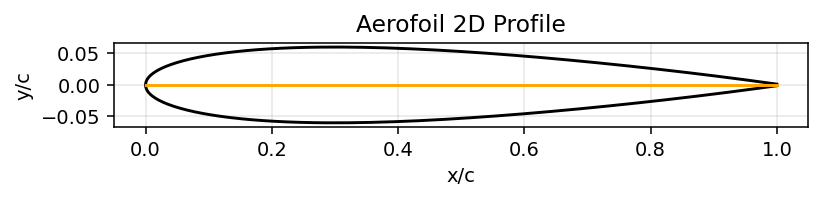

In [4]:
wbl_0012.aerofoil.show()

But it is recommended that properties of a `WingSection` are set via the `WingSections` dictionary-like object.

***
## 2) `WingSections` objects

`WingSections` (plural) objects can be thought of as a dictionary of `WingSection` (singular) objects, created by the user, that define the 3D geometry of the wing.
Users familiar with dictionaries should be comfortable with the concept that a dictionary can have a key-value pair designated with the following syntax:
    
    >>> my_dictionary[some_key] = some_value
    
    >>> print(my_dictionary)
    {some_key: some_value}

There are some key differences in how one uses `WingSections` objects versus regular dictionaries:

1. All keys are numeric.
2. Values can be interpolated, for keys that do not yet exist.
3. The only valid values of `WingSections` dictionaries are `WingSection` or `Aerofoil` objects.
4. Existing values from `WingSections` objects can be accessed with slices and arrays.

    >>> wing_sections_object[numeric_station] = wing_section_or_aerofoil_object
    
    >>> print(wing_sections_object)
    {numeric_station: wing_section_or_aerofoil_object}

We'll demonstrate these concepts more concretely with an example. Begin with the relevant import:

In [5]:
from carpy.geometry import WingSections

By default, the `WingSections` object is instantiated as "mirrored", so that users only need to define the aerofoil sections and geometry for half the wing - the other half of the wing is mirrored around the station with the smallest index.

In [6]:
# Define a mirrored wing geometry with a span of 10.6 metres
conceptwing = WingSections(b=10.6, mirrored=True)

# Prescribe geometry at a number of stations along the wing
conceptwing[-2] = naca2418  # <-- Centreline station, about which wing is mirrored
conceptwing[10] = naca2412
conceptwing[11.5] = naca0012

The important thing to remember about station numbers is that they are in proportion to each other's position along the span.
*You cannot prescribe a station 0 at position 0, station 10 at position 10, and then station 20 at position 100!*

Say we would like to prescribe a change in chord length at what would be the aerofoil at station 0.

In [7]:
# Take advantage of interpolation to make a copy of what a station 0 geometry currently looks like
station2modify = conceptwing[0]  # <-- This line produces a NEW WingSection object!

# Make a change to our fictitious station of the wing
station2modify.chord = 1.1

# Make the change a reality, by defining station 0 (which does not yet exist) in the concept wing
conceptwing[0] = station2modify  # <-- Instead of assigning an Aerofoil object, we're assigning a WingSection

print(conceptwing.items())  # <-- Now, we have a brand new station #0

dict_items([(-2.0, <carpy WingSection at 0x1f50f10be50>), (0.0, <carpy WingSection at 0x1f50f1275e0>), (10.0, <carpy WingSection at 0x1f50f086d00>), (11.5, <carpy WingSection at 0x1f57f9b9250>)])


One thing to be careful of is that if you request the value of a `WingSections` object at a station that is already defined, you will receive exactly the `WingSection` object that has been prescribed at that station - and therefore you can modify the `WingSections` object without actually having to reassign that wing section to the 3D wing geometry.

In [8]:
# Take the station with the lowest index
existing_section_number = list(conceptwing)[0]
existing_section = conceptwing[existing_section_number]

print(f"Existing station '{existing_section_number}' has a chord length of {existing_section.chord}.\n")

# Modify that station's chord
existing_section.chord = 1.2

# The concept wing has already updated its geometry
print(f"Modified station '{existing_section_number}' has a chord length of "
      f"{conceptwing[existing_section_number].chord} (despite not explicitly reassigning the station)")

Existing station '-2.0' has a chord length of 1.0 m.

Modified station '-2.0' has a chord length of 1.2 m (despite not explicitly reassigning the station)


To quickly modify parameters of a number of defined stations at once, say, to prescribe dihedral we can access many sections at once using Python slicing

In [9]:
import numpy as np

# Show to a reader that all defined WingSection objects can simply be taken with the slice [:]
np.array(list(conceptwing.values())) == conceptwing[:]

array([ True,  True,  True,  True])

In [10]:
# Add geometric twist station 10 and outwards
conceptwing[10:].twist = np.radians(-3)  # Wash out stations 10 and after by 3 degrees
print(f"{np.degrees(conceptwing[:].twist)=}\n")

# Define a dihedral angle for the whole wing
conceptwing[:].dihedral = np.radians(2)  # Up dihedral for all stations, 2 degrees
print(f"{np.degrees(conceptwing[:].dihedral)=}\n")

# Sweep the outboard two stations
conceptwing[10:].sweep = np.radians(1)  # Sweep stations after 10 by 1 degree
print(f"{np.degrees(conceptwing[:].sweep)=}")

np.degrees(conceptwing[:].twist)=array([ 0.,  0., -3., -3.])

np.degrees(conceptwing[:].dihedral)=array([2., 2., 2., 2.])

np.degrees(conceptwing[:].sweep)=array([0., 0., 1., 1.])


Section twist is a 2D parameter of a section, and is easy to determine by finding the angle in the X-Z plane between the section's chordline and the wing root chord.
Wings do not suddenly twist, and so segments of wing between two stations geometric twist linearly interpolate the twist.

In [11]:
# Twist linearly interpolates between stations
print(np.degrees(conceptwing[6].twist))

-1.8


Dihedral of a wing can also apply section-wise, however, it is unclear at a station coincident with the kink of a compound dihedral wing if the value of the dihedral is equal to the dihedral angle before or after the station.
For this reason, the dihedral angle defined at a station describes the dihedral angle of the segment of wing that follows the station; and unlike twist, does not make sense to linearly interpolate between stations.
As a result, the dihedral angle of an unknown, new station is inferred from the closest available inboard station.

In [12]:
# Dihedral is inherited from the closest inboard station
print(np.degrees(conceptwing[6].dihedral))

2.0


The same could be said about the wing's sweep angle

In [13]:
# Sweep is inherited from the closest inboard station
print(np.degrees(conceptwing[6].sweep))

0.0


You've now learned how to define a wing with definite span, chord length, twist, sweep, dihedral, and profile.
We can conveniently access geometric properties of the wing, such as its standard mean chord or aspect ratio:

In [14]:
attributes = ["AR", "MAC", "MGC", "SMC", "Sref", "Swet"]
print("; ".join([f"{x} = {getattr(conceptwing, x):.2f}" for x in attributes]))

AR = 10.01; MAC = 1.06 m; MGC = 1.06 m; SMC = 1.06 m; Sref = 11.23 m²; Swet = 23.10 m²


***
## 3) `AeroSolution` objects

It is possible to carry out a rudimentary analysis of wing performance in CARPy, returing `AeroSolution` objects.
These can be obtained through:

In [15]:
from carpy.aerodynamics import (
    PrandtlLLT,  # Prandtl's lifting line theory for unswept wings
    HorseshoeVortex,  # Span-wise horseshoe vortex method
    MixedBLDrag,  # Mixed boundary layer method for skin friction drag
)

All derivative methods of `AeroSolution` have similar instantiation structures.

#### `PrandtlLLT`

PrandtlLLT is limited in analysis to unswept wings, full details in the docstring.

In [16]:
from carpy.utility import Quantity, constants as co

# Apply Horseshoe Vortex to the symmetrical wing
flightconditions = {"altitude": 0, "TAS": Quantity(185, "kt"), "alpha": np.radians(5)}
soln0 = PrandtlLLT(wingsections=conceptwing, **flightconditions)

public_attributes = [x for x in dir(soln0) if not x.startswith("_")]
print(f"{public_attributes=}\n")

print(soln0)

public_attributes=['CD', 'CD0', 'CDi', 'CDw', 'CL', 'CY', 'Cl', 'Cm', 'Cn', 'Cni', 'TAS', 'alpha', 'altitude', 'atmosphere', 'beta', 'geometric', 'sections', 'x_cp']

** <carpy WingSections at 0x1f50efd3680> **
 CD  =  0.008389    CY  =  0.000000    CL  =  0.510985
 CD0 =       NAN    CDi =  0.008389    CDw =       NAN
 Cl  =       NAN    Cm  =       NAN    Cn  =       NAN
 Cli =       NAN    Cmi =       NAN    Cni =       NAN


#### `HorseshoeVortex`

Horseshoe Vortex methods applied to the same wing take longer, but permit the analysis of asymmetric wings, section-wise lift coefficients, and even centre of pressure.

##### <span style="color:red">IMPORTANT NOTE</span>:

Users are asked to note that currently, this method assumes the centre of pressure for each vortex element sweeps by the same amount the leading edge does. This requires a fix in future, but for now, defining a leading edge sweep of 0 actually returns the performance of a wing where the section-wise centre of pressure has a sweep of 0 besides the dihedral direction (i.e. leading edge sweep varies unexpectedly).

In [17]:
# Apply Horseshoe Vortex to the symmetrical wing
soln1 = HorseshoeVortex(wingsections=conceptwing, **flightconditions)

public_attributes = [x for x in dir(soln1) if not x.startswith("_")]
print(f"{public_attributes=}\n")

print(soln1)

public_attributes=['CD', 'CD0', 'CDi', 'CDw', 'CL', 'CY', 'Cl', 'Cm', 'Cn', 'Cni', 'TAS', 'alpha', 'altitude', 'atmosphere', 'beta', 'geometric', 'sections', 'x_cp']

** <carpy WingSections at 0x1f50efd3680> **
 CD  =  0.007263    CY  =  0.000000    CL  =  0.446525
 CD0 =       NAN    CDi =  0.007263    CDw =       NAN
 Cl  =       NAN    Cm  =       NAN    Cn  =       NAN
 Cli =       NAN    Cmi =       NAN    Cni =       NAN


#### `MixedBLDrag`

CARPy provides means of estimating skin friction drag for a generic wing with surface quality specified by providing the `Ks` (equivalent sand grain roughness).

The component of drag due to skin friction can be estimated from definitions of geometry and the relevant flight conditions:

In [18]:
from carpy.utility import constants as co

# Make a drag prediction
soln2 = MixedBLDrag(
    wingsections=conceptwing,  # <-- Geometry
    **flightconditions,  # <-- Flight conditions
    Ks=float(co.MATERIAL.roughness_Ks.paint_matte_smooth)
)

public_attributes = [x for x in dir(soln2) if not x.startswith("_")]
print(f"{public_attributes=}\n")

print(soln2)

public_attributes=['CD', 'CD0', 'CDf', 'CDf_CD0', 'CDi', 'CDw', 'CL', 'CY', 'Cf', 'Cl', 'Cm', 'Cn', 'Cni', 'TAS', 'alpha', 'altitude', 'atmosphere', 'beta', 'geometric', 'sections', 'x_cp']

** <carpy WingSections at 0x1f50efd3680> **
 CD  =  0.004864    CY  =       NAN    CL  =       NAN
 CD0 =  0.004864    CDi =       NAN    CDw =       NAN
 Cl  =       NAN    Cm  =       NAN    Cn  =       NAN
 Cli =       NAN    Cmi =       NAN    Cni =       NAN


#### `HoernerCable`

_Coming Soon_

### Combining Performance Estimates

There exist a plethora of methods to predict drag, however, not all approaches are used to compute the same components.
In this section, we'll look at some different ways that drag models can be combined.

#### `Union`

Models that compute the lift-induced drag $C_{D_{i}}$ but not the profile drag $C_{D_{0}}$ (and vice versa) can be combined with a _union_ operation.
Fortunately, it is easy to combine models using the _set union_ pipe `|` operator (on most computers, this is found by pressing `SHIFT`+`\`):

In [19]:
print(f"PrantlLLT result:\n{soln0}\n")
print(f"Horseshoe result:\n{soln1}\n")

# Let's say I would like the worse CDi of Prandtl, to combine with the worse CL of the Horseshoe

# If soln0 and soln1 disagree on performance parameter, prefer soln0 (left most soln)
del soln0.CL  # Remove the good CL estimate, so it can be replaced during Union
combined_result = soln0 | soln1

print(f"Combined result:\n{combined_result}")

PrantlLLT result:
** <carpy WingSections at 0x1f50efd3680> **
 CD  =  0.008389    CY  =  0.000000    CL  =  0.510985
 CD0 =       NAN    CDi =  0.008389    CDw =       NAN
 Cl  =       NAN    Cm  =       NAN    Cn  =       NAN
 Cli =       NAN    Cmi =       NAN    Cni =       NAN

Horseshoe result:
** <carpy WingSections at 0x1f50efd3680> **
 CD  =  0.007263    CY  =  0.000000    CL  =  0.446525
 CD0 =       NAN    CDi =  0.007263    CDw =       NAN
 Cl  =       NAN    Cm  =       NAN    Cn  =       NAN
 Cli =       NAN    Cmi =       NAN    Cni =       NAN

Combined result:
** <carpy WingSections at 0x1f50efd3680> **
 CD  =  0.008389    CY  =  0.000000    CL  =  0.446525
 CD0 =       NAN    CDi =  0.008389    CDw =       NAN
 Cl  =       NAN    Cm  =       NAN    Cn  =       NAN
 Cli =       NAN    Cmi =       NAN    Cni =       NAN


Combinations are legal so long as the performance methods operate on the same `WingSections` object, and there are no conflicts in the designed flight conditions (the solutions are considered compatible).

#### `Addition`

Like the union operator, addition allows users to combine separate drag predictions, albeit in a slightly different manner.
Under the hood, a union is first carried out - and then followed by an operation that additively combines drag between different models.
This is useful to determine the total profile drag, for example, by combining two models that estimate the zero-lift and lift-induced components of profile drag, respectively.

In [20]:
print(f"Horseshoe result:\n{soln1}\n")
print(f"MixedBL result:\n{soln2}\n")

# Do union in the background, and then stack drag effects
combined_result = soln1 + soln2

print(f"Combined result:\n{combined_result}")

Horseshoe result:
** <carpy WingSections at 0x1f50efd3680> **
 CD  =  0.007263    CY  =  0.000000    CL  =  0.446525
 CD0 =       NAN    CDi =  0.007263    CDw =       NAN
 Cl  =       NAN    Cm  =       NAN    Cn  =       NAN
 Cli =       NAN    Cmi =       NAN    Cni =       NAN

MixedBL result:
** <carpy WingSections at 0x1f50efd3680> **
 CD  =  0.004864    CY  =       NAN    CL  =       NAN
 CD0 =  0.004864    CDi =       NAN    CDw =       NAN
 Cl  =       NAN    Cm  =       NAN    Cn  =       NAN
 Cli =       NAN    Cmi =       NAN    Cni =       NAN

Combined result:
** <carpy WingSections at 0x1f50efd3680> **
 CD  =  0.012127    CY  =  0.000000    CL  =  0.446525
 CD0 =  0.004864    CDi =  0.007263    CDw =  0.000000
 Cl  =       NAN    Cm  =       NAN    Cn  =       NAN
 Cli =       NAN    Cmi =       NAN    Cni =       NAN


***
## *Future* objects

The plan is to eventually supercede `WingSolution` (valid for a very particular set of flight conditions) with an object that will conveniently interpolate lift, drag, centre of pressure, and other metrics of wing performance as a function of the wing's angle of attack.

For now, the burden is upon CARPy's users (sorry!).